# Search for Landsat Scenes

## Introduction

In this notebook, we use the USGS API to find usable Landsat scenes in NYC over the summer. The steps are

- In [Section 1](#search), we:

    1. Perform a dataset search using the USGS API. We input the aliases of the desired datasets, Landsats 5 and 8, to obtain a list of dataset objects.
    2. For every dataset object, search for scenes that contain lower left (`ll`) and upper right (`ur`) longitude and latitude coordinates of a square encompassing NYC. These values are provided to the API as a dictionary of latitudes and longitudes. 
    3. Filter the resulting scenes by ones with:
        - Less than 10% cloud cover
        - Areas that contain the upper left `ul` and lower right `lr` corners of a square encompassing NYC. 

- In [Section 2](#saveids) we export a list of the `displayId`s of the scenes to a text file. (A displayId is a USGS identifier for the scene.)
- In [Section 3](#plot) we explore the saved scenes in more detail. We print the cloud cover values for every scene in a user-specified year, and we plot the Landsat image. 

At the end of this notebook, we include

1. [A short section](#landsat7) in which Landsat 7 scenes are plotted. There we see that the data from this satellite is not usable.
2. [Instructions](#download) on how to download Landsat data. Once the text file of scenes IDs is created in Section 2, users can upload the file to EarthExplorer's bulk downloader to access the files. 

**NOTE**: User must input their USGS EROS username and password in [Section 1](#search) of this notebook.

## Results

For the summers of 1980-2021, we find 114 scenes satisfying our cloud cover and spacial coverage criteria. These results are saved to a text file in `02-data/scene-search`. 

[Section 3](#plot) of this notebook can be used to plot jpegs of the raw Landsat scenes. 

## Data

No data is imported into this notebook. Text files containing scene searches are exported to the directory `02-data/scene-search`.   


In [1]:
import os
import sys

"""Add the 01-scripts/ folder to the load path to import from there"""
dir_parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
dir_scripts = dir_parent + "/01-scripts"
sys.path.append(dir_scripts)

import usgsAPI # Script I wrote

# For plotting
import matplotlib.pyplot as plt

DIR_EXPORT = dir_parent+"/02-data/scene-search"
DIR_FIGS = dir_parent + "/03-figs"

## 1. Search for scenes <a id="search"></a>

In [2]:
# Login to the USGS 
username = 'USERNAME'
password = 'PASSWORD'

api_key = usgsAPI.login(username, password)

In [5]:
# Uncomment this to logout of the API
# usgsAPI.logout(api_key)

In [3]:
## USER INPUTS ####################################
year_start = 1980
year_end = 2022
############################### END USER INPUTS ##

# Manually inputting NYC bounds
ll = {"latitude": 40.5378, "longitude": -74.0520}
ur = {"latitude": 40.9260, "longitude": -73.6963}
lr = {"latitude": 40.5378, "longitude": -73.6963}
ul = {"latitude": 40.9260, "longitude": -74.0520}

The USGS API provides access to many different datasets. Each one has its own alias, which has to be provided to the `dataset_search` or `dataset_search_multi` function. The aliases that we may find useful are summarized in the following table. 

**Collection 1**

|Alias| Description |
|-----|-------------|
|landsat_tm_c1 | Landsat 4-5 Thematic Mapper Collection 1 Level-1 |
|lsr_landsat_tm_c1 | Landsat 4-5 Collection 1 Level-2 Scene Products (Surface Reflectance) |
|landsat_8_c1 | Landsat 8 Operational Land Imager and Thermal Infrared Sensor Collection 1 Level-1 |
|lsr_landsat_8_c1 | Landsat 8 Collection 1 Level-2 Scene Products (Surface Reflectance) |
|landsat_etm_c1 |  Landsat 7 Enhanced Thematic Mapper Plus Collection 1 Level-1 |
|lsr_landsat_etm_c1 | Landsat 7 Collection 1 Level-2 Scene Products (Surface Reflectance) |


**Collection 2**

|Alias| Description |
|-----|-------------|
|landsat_tm_c2_l1 | Landsat 4-5 Thematic Mapper Collection 2 Level-1 |
|landsat_tm_c2_l2 | Landsat 4-5 Thematic Mapper Collection 2 Level-2 |
|landsat_ot_c2_l1 | Landsat 8 Operational Land Imager and Thermal Infrared Sensor Collection 2 Level-1 |
|landsat_ot_c2_l2 | Landsat 8 Operational Land Imager and Thermal Infrared Sensor Collection 2 Level-2 |
|landsat_etm_c2_l1 | Landsat 7 Enhanced Thematic Mapper Plus Collection 2 Level-1 |
|landsat_etm_c2_l2 | Landsat 7 Enhanced Thematic Mapper Plus Collection 2 Level-2 |

In [4]:
# aliases = ["landsat_ot_c2_l1","landsat_tm_c2_l1"] # COLLECTION 2
aliases = ["landsat_8_c1","landsat_tm_c1"] # COLLECTION 1

print("Retrieving Landsat datasets...")
datasets = usgsAPI.dataset_search_multi(api_key, aliases)
print("Found ", len(datasets), "/",len(aliases)," desired datasets.")

print("\nSearching scenes...")
scene_list_raw = usgsAPI.scene_search_multi(api_key, datasets, year_start, 
                                            year_end, ll, ur)
"""
Note on scene_search_multi: The function returns a nested list of scenes, 
e.g. [[scene1], [scene2,scene3], [scene4]]. We flatten this with the 
following line:
"""
scene_list_raw_flatten = [item for sublist in scene_list_raw 
                          for item in sublist]
print("Found ", len(scene_list_raw_flatten), " NYC summer scenes.")

print("\nFiltering for cloud cover < 10%")
filtered_cloud_cover = usgsAPI.filter_cloud_cover(scene_list_raw_flatten, 
                                                  10.0)
print("Found ", len(filtered_cloud_cover), " scenes with desired cloud cover.")

print("\nFiltering for scene containing all of NYC")
filtered_scenes = usgsAPI.filter_lr_ul(filtered_cloud_cover, lr, ul)
print("Found ", len(filtered_scenes), " scenes containing LR and UL corners.")

Retrieving Landsat datasets...
Found  2 / 2  desired datasets.

Searching scenes...
Found  620  NYC summer scenes.

Filtering for cloud cover < 10%
Found  152  scenes with desired cloud cover.

Filtering for scene containing all of NYC
Found  114  scenes containing LR and UL corners.


In [5]:
"""
Check that the number of items in raw scene list matches the
length of the flattened list. Want to check that I'm not missing anything."""
num_scenes = 0
for item in scene_list_raw:
    num_scenes = num_scenes + len(item)
print("Same number of scenes = ", len(scene_list_raw_flatten) == num_scenes)

Same number of scenes =  True


## 2.  Save filtered scene displayIds to a text file <a id="saveids"></a>

In [6]:
# First make a list of displayIds
scene_ids = []
for sc in filtered_scenes:
    # print("Id = ",sc["entityId"],", ",sc["temporalCoverage"], \
        # ", cloudCover =", sc["cloudCover"])
    scene_ids.append(sc["displayId"])

# Then write to a text file. Change the name to whatever you would like.  
textfile = open(DIR_EXPORT + "/scene_c1_l1_displayIds.txt", "w")
for element in scene_ids:
    textfile.write(element + "\n")
    print(element)
textfile.close()

LC08_L1TP_014032_20130820_20170309_01_T1
LC08_L1TP_013032_20140917_20170303_01_T1
LC08_L1TP_014032_20140807_20170304_01_T1
LC08_L1TP_013032_20140731_20170304_01_T1
LC08_L1TP_014032_20140706_20170304_01_T1
LC08_L1TP_014032_20150826_20170225_01_T1
LC08_L1TP_013032_20150803_20170226_01_T1
LC08_L1TP_014032_20150725_20170226_01_T1
LC08_L1TP_014032_20160828_20170221_01_T1
LC08_L1TP_014032_20160812_20170222_01_T1
LC08_L1TP_013032_20160805_20170222_01_T1
LC08_L1TP_014032_20160727_20170222_01_T1
LC08_L1TP_013032_20160720_20170222_01_T1
LC08_L1TP_013032_20170909_20170927_01_T1
LC08_L1TP_014032_20170730_20170811_01_T1
LC08_L1TP_014032_20180903_20180912_01_T1
LC08_L1TP_013032_20180710_20180717_01_T1
LC08_L1TP_014032_20190922_20190926_01_T1
LC08_L1TP_013032_20190830_20190916_01_T1
LC08_L1TP_013032_20190729_20190801_01_T1
LC08_L1TP_013032_20190713_20190719_01_T1
LC08_L1TP_014032_20210826_20210901_01_T1
LT05_L1TP_014032_19840921_20161004_01_T1
LT05_L1TP_014032_19840719_20161004_01_T1
LT05_L1TP_013032

## 3. Explore specific years  <a id="plot"></a>

In this section we explore specific years of Landsat 5 and 8 data. First, we print the cloud cover for every scene for the selected `year_choice`. Then, we plot the Landsat image using the `view_scene` helper function available in the `usgsAPI.py` script. 

Looking more closely at 2021, we see that there is only one scene 2021. Let us view the results for that year to see why. 

In [6]:
year_choice = "2015"
scenes_subset = []

for sc in scene_list_raw_flatten:
    if year_choice in sc["temporalCoverage"]["endDate"]:
        scenes_subset.append(sc)
        print(sc["cloudCover"])
print("Number of scenes = ", len(scenes_subset))

-1.00
-1.00
59.99
48.58
78.03
-1.00
-1.00
53.26
16.47
6.35
-1.00
-1.00
12.54
61.98
73.17
-1.00
-1.00
3.49
12.07
1.93
-1.00
-1.00
90.45
94.74
88.48
87.37
91.18
99.91
Number of scenes =  28


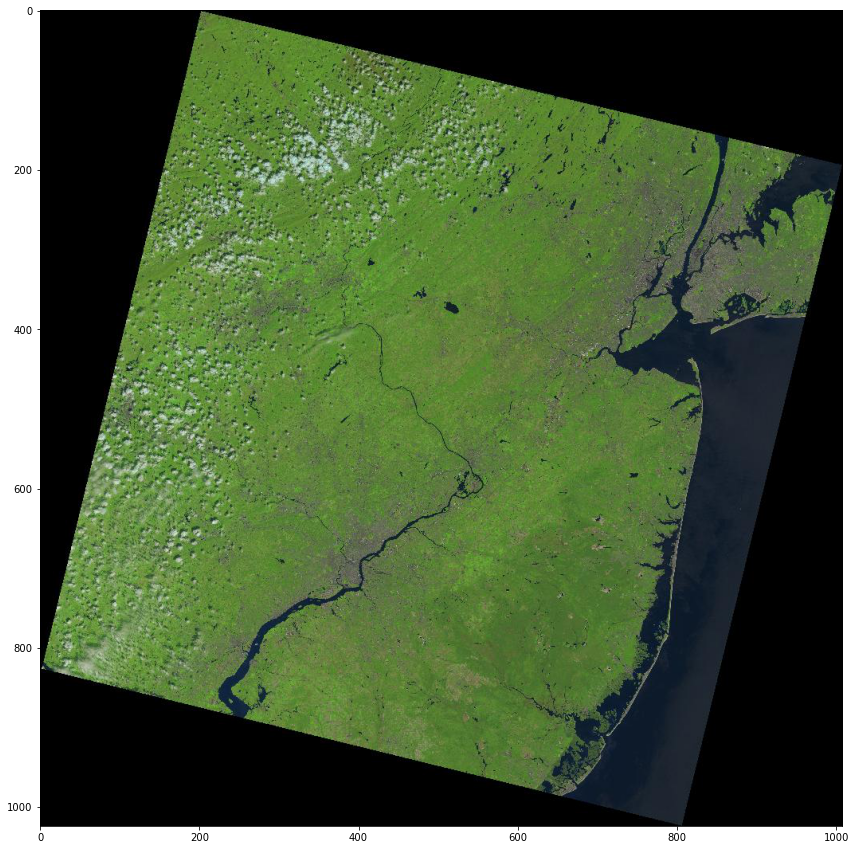

In [7]:
"""
Select a scene by choosing a number between 0 and (number of scenes)-1
"""
scene_selection = 9

plt.rcParams["figure.figsize"] = (15,15)
    
url = usgsAPI.view_scene(scenes_subset[scene_selection])

In [9]:
scenes_subset[scene_selection]["browse"][0]["browsePath"]

'https://ims.cr.usgs.gov/browse/landsat_8_c1/2015/014/032/LC08_L1TP_014032_20150826_20170225_01_T1.jpg'

Search for Level-2 scenes with the same cloud cover criteria. 

## Search Landsat 7 <a id="landsat7"></a>

Hoping that Landsat 7 might have some cloudless scenes in 2021, we search that database. We find that all of the satellite data has streaks in it, so cannot be used. 

In [9]:
l7_alias = "landsat_etm_c1"
date_start = "2021-06-21"
date_end = "2021-09-22"

dataset7 = usgsAPI.dataset_search(api_key, l7_alias, "EE")[0]
scene_list_l7 = usgsAPI.scene_search(api_key, dataset7, 5000, None, \
                                     date_start, date_end, ll, ur)["results"]
# scene_list_l7 = [item for sublist in scene_list_l7 for item in sublist]
print("Found ", len(scene_list_l7), "scenes.")

print("\nFiltering for cloud cover < 5%")
filtered_cloud_cover_l7 = usgsAPI.filter_cloud_cover(scene_list_l7, 5.0)
print("Found ", len(filtered_cloud_cover_l7), \
      " scenes with desired cloud cover.")

print("\nFiltering for scene containing all of NYC")
filtered_scenes_l7 = usgsAPI.filter_lr_ul(filtered_cloud_cover_l7, lr, ul)
print("Found ", len(filtered_scenes_l7), \
      " scenes containing LR and UL corners.")

Found  18 scenes.

Filtering for cloud cover < 5%
Found  5  scenes with desired cloud cover.

Filtering for scene containing all of NYC
Found  4  scenes containing LR and UL corners.


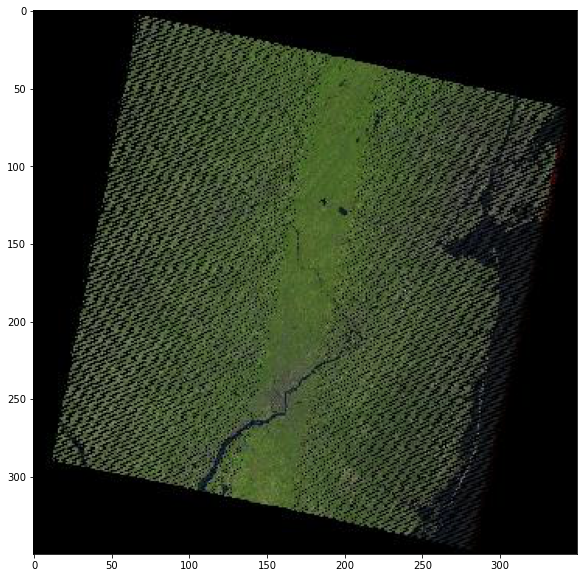

In [11]:
"""
Select a scene to display by choosing a number between 
0 and (number of scenes)-1
"""
scene_selection = 0

plt.rcParams["figure.figsize"] = (10,10)
    
usgsAPI.view_scene(filtered_scenes_l7[scene_selection])

## Download scenes <a id="download"></a>

It would be nice to download scenes here directly by submitting a request through USGS. This is only possible if you make a request to use to the USGS to use the download feature. (It takes about a week to be approved.) A faster solution is to use the bulk downloader. The steps are:

1. **Install the bulk downloader application from [USGS](https://dds.cr.usgs.gov/bulk).** For Linux, I had to first install Java 11 in my local directory. (The webpage says Java 10 is sufficient, but this is a lie.) To run the installer, I define the `INSTALL4J_JAVA_HOME` variable in my `.bash_profile` file. After refreshing terminal (or just loading the editted `.bash_profile` as the source), I make the downloaded installer executable and run it through command line. When it asks for download locations, make sure to select ones within the local directory. To run the program in the future, navigate to the executable in install directory you chose.
2. **Create a bulk download request.** In the [EarthExplorer](https://earthexplorer.usgs.gov/) webpage, select `Manage Criteria`. Click on `Scene Lists` in the left menu. Then click on Landsat Product ID list. Copy and paste the Landsat IDs that were saved to `scene_displayIDs.txt` into the text box. Then click upload. 
3. The next page asks you to select the type of image you would like for every single scene. Instead of this, click the `Options` button and select the Level-1 option, which should then select this for all the scenes.
4. **Download scenes.** Follow instructions within the bulk downloader to select scenes. 

**NOTE:** Even though USGS encourages us to use Collection 2 Landsat data, the bulk-download request returns an error whenever a Collection 2 scene is requested. This is why only Collection 1 scenes were used. 